### import necessary libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from resources.arabic_preprocessing import Arabic_preprocessing
from nltk.stem.arlstem import ARLSTem
import gensim
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

print(tf.__version__)
tf.set_random_seed(121)

1.7.0


### initialize embeddings, stemmer, preprocessing

In [6]:
prep = Arabic_preprocessing()
stemmer = ARLSTem()

emb_path = '../resources/(cbow58)-asa-3b-cbow-window5-3iter-d300-vecotrs.bin'
new_emb = gensim.models.KeyedVectors.load_word2vec_format(emb_path, binary=True, unicode_errors='ignore')

### Read ASTD dataset

In [9]:
df=pd.read_csv('tmp/data/ASTD-unbalanced.csv', delimiter=',', skiprows=1, header=None, names=['tweet','sentiment'])
df.head()

,tweet,sentiment
0,اهنئ الدكتور احمد جمال الدين القيادي بحزب مصر ...,1
1,امير عيد هو اللي فعلا يتقال عليه ستريكر صريح ك...,1
2,الصداقه تزرع الحياه ازهارا مي زياده,1
3,دضياء رشوان ان الدكتور عبد المنعم ابو الفتوح ا...,1
4,الى زملائي المحامين الراغبين في الانضمام لمباد...,1


### preprocess tweets

In [10]:
df['tweet_preprocessed'] = df['tweet'].apply(lambda x : prep.preprocess_arabic_text(x, stem=False, replace_emojis=True, normalize_arabic=True))
df.head()

,tweet,sentiment,tweet_preprocessed
0,اهنئ الدكتور احمد جمال الدين القيادي بحزب مصر ...,1,اهنئ الدكتور احمد جمال الدين القيادي بحزب مصر ...
1,امير عيد هو اللي فعلا يتقال عليه ستريكر صريح ك...,1,امير عيد فعلا يتقال ستريكر صريح كاريوكي السكه
2,الصداقه تزرع الحياه ازهارا مي زياده,1,الصداقه تزرع الحياه ازهارا مي زياده
3,دضياء رشوان ان الدكتور عبد المنعم ابو الفتوح ا...,1,دضياء رشوان الدكتور عبد المنعم الفتوح الاكثر ا...
4,الى زملائي المحامين الراغبين في الانضمام لمباد...,1,زملائي المحامين الراغبين الانضمام لمبادره سامع...


### prepare labels (one-hot encoding)

In [14]:
y = df.sentiment.values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
onehot_encoder = OneHotEncoder(sparse=False)
y = onehot_encoder.fit_transform(y_encoded.reshape((-1,1)))
print(y.shape)

(2161, 2)


### Tweets to embeddings + split train, test

In [15]:
def max_length(tweets_list):
    tweets_length = [len(tweet.split(' ')) for tweet in tweets_list]
    return max(tweets_length)

def apply_embeddings(embeddings, tweets, stemmer, max_len):
    shape = (len(tweets), 300, max_len)
    X_emb = np.zeros(shape)
    for i, tweet in enumerate(tweets):
        for j,word in enumerate(tweet.split()):
            if word in embeddings:
                X_emb[i,:,j] = embeddings[word]
            elif stemmer.stem(word) in embeddings:
                X_emb[i,:,j] = embeddings[stemmer.stem(word)]
            else:
                X_emb[i,:,j] = np.zeros((300,))
    return X_emb


#scaler = MinMaxScaler()
XX = df.tweet_preprocessed.tolist()
max_len = max_length(XX)
print('max_len', max_len)
X_emb = apply_embeddings(new_emb, XX, stemmer, max_len)
print('X_emb.shape:', X_emb.shape)

X_train, X_test, y_train, y_test = train_test_split(X_emb, y, test_size=0.2, shuffle=True, random_state=121)
X_train = np.reshape(X_train, X_train.shape + (1,))
X_test = np.reshape(X_test, X_test.shape + (1,))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

max_len 23
X_emb.shape: (2161, 300, 23)
(1728, 300, 23, 1) (1728, 2)
(433, 300, 23, 1) (433, 2)


### Model parameters

In [16]:
vocab_size = len(new_emb.vocab)
embeddings_length = new_emb.vector_size
nb_classes = 2 # binary sentiment
nb_filters = 200
sentence_max_length = max_len
rnn_output_size = 100
hidden_dim = 400 # the number of neurons in the hidden, fully connected layer
learning_rate = 0.00001
nb_epochs = 10
batch_size = 32
nb_samples = X_train.shape[0]

### build model graph
<img src="images/CNN_RNN_sentiment.png" alt="CNN_RNN_sentiment" title="CNN_RNN_sentiment" height="420" width="720"/>

In [17]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, 300, sentence_max_length, 1), name='input')
y = tf.placeholder(tf.float32, shape=(None, nb_classes), name='output')
drop_flag = tf.placeholder_with_default(True, shape=())

with tf.name_scope('Convolution_4'):
    conv4 = tf.layers.conv2d(inputs=X, filters=nb_filters, kernel_size=(embeddings_length,4), padding='valid', name='conv4')
    maxpool4 = tf.layers.max_pooling2d(inputs=conv4, pool_size=(1,2), strides=2, padding='valid', name='maxpooling4')
    #batch_norm = tf.layers.batch_normalization()
    layer1 = tf.nn.relu(maxpool4, name='ReLU4')
    #layer1 = tf.nn.leaky_relu(maxpool4, alpha=0.1, name='LeakyReLU4')
    print(layer1)

with tf.name_scope('Convolution_5'):
    conv5 = tf.layers.conv2d(inputs=X, filters=nb_filters, kernel_size=(embeddings_length,5), padding='valid', name='conv5') # 1 x (sentence_max_length-5+1)
    maxpool5 = tf.layers.max_pooling2d(inputs=conv5, pool_size=(1,2), strides=2, padding='same', name='maxpooling5')
    #batch_norm = tf.layers.batch_normalization()
    layer2 = tf.nn.relu(maxpool5, name='ReLU5')
    #layer2 = tf.nn.leaky_relu(maxpool5, alpha=0.1, name='LeakyReLU5')
    print(layer2)

with tf.name_scope('Concatination'):
    concat = tf.concat([layer1, layer2], -1)
    concat = tf.reshape(concat, (-1, concat.shape[-2], concat.shape[-1]))
    concat = tf.layers.dropout(concat, rate=0.2, training=drop_flag, name='dropout_concat')
    #concat = tf.layers.batch_normalization(concat, training=drop_flag, name='batch_normalization_concat')
    print(concat)
    

gru = tf.keras.layers.LSTM(rnn_output_size) (concat) # 100   # , dropout=0.2, recurrent_dropout=0.2
#gru = tf.layers.dropout(gru, rate=drop_prob, name='dropout_gru')

#fully_connected = tf.layers.dense(gru, hidden_dim, kernel_initializer=tf.keras.initializers.he_normal(),
#                                 kernel_constraint=tf.keras.constraints.max_norm(3), bias_constraint=tf.keras.constraints.max_norm(3))
#fully_connected = tf.layers.dense(gru, hidden_dim, kernel_initializer=tf.keras.initializers.he_normal())
#fully_connected = tf.nn.leaky_relu(fully_connected, alpha=0.1, name='LeakyReLU')
#fully_connected = tf.nn.relu(fully_connected, name='ReLU_dense1')
#fully_connected = tf.layers.dropout(fully_connected, rate=0.5, training=drop_flag, name='dropout_dense1')

logits = tf.layers.dense(inputs=gru, units=nb_classes, name='output_layer')
#logits = tf.nn.leaky_relu(logits, name='LeakyReLU_output')
logits = tf.nn.relu(logits, name='ReLU_output')

Tensor("Convolution_4/ReLU4:0", shape=(?, 1, 10, 200), dtype=float32)
Tensor("Convolution_5/ReLU5:0", shape=(?, 1, 10, 200), dtype=float32)
Tensor("Concatination/dropout_concat/cond/Merge:0", shape=(?, 10, 400), dtype=float32)


### define loss function, optimizer, accuracy...

In [18]:
loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=tf.cast(y, tf.int32), logits=logits))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
correct_predictoins = tf.equal(tf.argmax(y,1), tf.argmax(logits,1))
accuracy = tf.reduce_mean(tf.cast(correct_predictoins, tf.float32))

### Mini-batch training

In [19]:
def next_batch(X, y, counter, batch_size):
    start_index = counter * batch_size
    end_index = start_index + batch_size
    #if end_index > X.shape[0]: end_index = X.shape[0]
    return X[start_index:end_index], y[start_index:end_index], start_index, end_index

init = tf.global_variables_initializer()

accuracy_train, accuracy_test = [], []
loss_train, loss_test = [], []

with tf.Session() as sess:
    sess.run(init)
    nb_batches = int(nb_samples / batch_size)
    
    acc_test, err_test, y_pred = sess.run([accuracy, loss, logits], feed_dict={X:X_test, y:y_test, drop_flag:False})
    loss_test.append(err_test)
    
    for epoch in np.arange(nb_epochs):
        
        batch_counter = 0
        
        for one_batch in tqdm(np.arange(nb_batches)):
            batch_x, batch_y, _, _ = next_batch(X_train, y_train, batch_counter, batch_size)
            #_ = sess.run(optimizer, feed_dict={X:batch_x.reshape((-1,28,28,1)), y:batch_y})
            _ = sess.run(optimizer, feed_dict={X:batch_x, y:batch_y, drop_flag:True})
            batch_counter += 1
        
        acc_train, err_train = sess.run([accuracy, loss], feed_dict={X:X_train, y:y_train, drop_flag:False})
        acc_test, err_test, y_pred = sess.run([accuracy, loss, logits], feed_dict={X:X_test, y:y_test, drop_flag:False})
        accuracy_train.append(acc_train)
        accuracy_test.append(acc_test)
        loss_train.append(err_train)
        loss_test.append(err_test)
        
        print('epoch:', int(epoch+1), ' -- training accuracy:', acc_train, ' -- test accuracy:', acc_test)

print("\nTraining complete!  :)")

100%|████████████████████████████████████████████████████████████████| 54/54 [00:07<00:00,  7.19it/s]


epoch: 1  -- training accuracy: 0.7251157  -- test accuracy: 0.6905312


100%|████████████████████████████████████████████████████████████████| 54/54 [00:06<00:00,  9.00it/s]


epoch: 2  -- training accuracy: 0.7708333  -- test accuracy: 0.73903


100%|████████████████████████████████████████████████████████████████| 54/54 [00:05<00:00,  9.07it/s]


epoch: 3  -- training accuracy: 0.8032407  -- test accuracy: 0.7852194


100%|████████████████████████████████████████████████████████████████| 54/54 [00:06<00:00,  8.74it/s]


epoch: 4  -- training accuracy: 0.8240741  -- test accuracy: 0.812933


100%|████████████████████████████████████████████████████████████████| 54/54 [00:05<00:00,  9.11it/s]


epoch: 5  -- training accuracy: 0.8385417  -- test accuracy: 0.82448035


100%|████████████████████████████████████████████████████████████████| 54/54 [00:06<00:00,  8.99it/s]


epoch: 6  -- training accuracy: 0.8501157  -- test accuracy: 0.8383372


100%|████████████████████████████████████████████████████████████████| 54/54 [00:06<00:00,  8.60it/s]


epoch: 7  -- training accuracy: 0.8559028  -- test accuracy: 0.83602774


100%|████████████████████████████████████████████████████████████████| 54/54 [00:06<00:00,  8.65it/s]


epoch: 8  -- training accuracy: 0.8668981  -- test accuracy: 0.8383372


100%|████████████████████████████████████████████████████████████████| 54/54 [00:06<00:00,  8.91it/s]


epoch: 9  -- training accuracy: 0.8773148  -- test accuracy: 0.83602774


100%|████████████████████████████████████████████████████████████████| 54/54 [00:05<00:00,  9.06it/s]


epoch: 10  -- training accuracy: 0.8859954  -- test accuracy: 0.8314088

Training complete!  :)


### plot accuracy

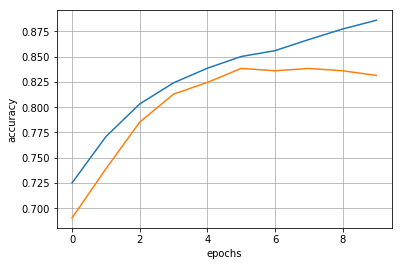

In [20]:
plt.plot(accuracy_train)
plt.plot(accuracy_test)
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()